In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holidays

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.utils import resample

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, Sampler

import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import BasePredictionWriter

In [9]:
def convert_to_quarterly(data):

    # Remove unnecessary columns
    data = data.drop(columns=['Zip_Postal_Code'])

    # Convert date/time columns to datetime
    data['Start_DateTime'] = pd.to_datetime(data['Start_DateTime'])
    data['Charging_EndTime'] = pd.to_datetime(data['End_DateTime'])
    data['Charging_Time'] = pd.to_timedelta(data['Charging_Time'])

    ####################### CONVERT DATASET TO QUARTERLY  #######################

    # Split the session into quarterly intervals
    quarterly_rows = []

    # Iterate over each row in the dataframe to break charging sessions into quarterly intervals
    for _, row in data.iterrows():
        start, end = row['Start_DateTime'], row['Charging_EndTime']
        energy = row['Energy_Consumption']

        # Generate quarterly intervals
        quarterly_intervals = pd.date_range(start=start.floor(
            '15min'), end=end.ceil('15min'), freq='15min')
        total_duration = (end - start).total_seconds()

        for i in range(len(quarterly_intervals) - 1):
            interval_start = max(start, quarterly_intervals[i])
            interval_end = min(end, quarterly_intervals[i+1])
            interval_duration = (interval_end - interval_start).total_seconds()

            # Calculate the energy consumption for the interval if interval is greater than 0 (Start and end time are different)
            if interval_duration > 0:
                energy_fraction = (interval_duration / total_duration) * energy

            quarterly_rows.append({
                'Time': quarterly_intervals[i],
                'Energy_Consumption': energy_fraction,
                "Session_Count": 1  # Count of sessions in the interval
            })

    quarterly_df = pd.DataFrame(quarterly_rows)

    quarterly_df = quarterly_df.groupby('Time').agg({
        'Energy_Consumption': 'sum',
        'Session_Count': 'sum'
    }).reset_index()

    # Convert the Time column to datetime
    quarterly_df['Time'] = pd.to_datetime(
        quarterly_df['Time'], format="%d-%m-%Y %H:%M:%S")
    quarterly_df = quarterly_df.set_index('Time')

    # Define time range for all 24 hours
    start_time = quarterly_df.index.min().normalize()  # 00:00:00
    end_time = quarterly_df.index.max().normalize() + pd.Timedelta(days=1) - \
        pd.Timedelta(hours=1)  # 23:00:00

    # Change range to time_range_full, so from 00:00:00 to 23:00:00
    time_range_full = pd.date_range(
        start=start_time, end=end_time, freq='15min')

    quarterly_df = quarterly_df.reindex(time_range_full, fill_value=0)

    return quarterly_df


def add_features(df):
  ####################### TIMED BASED FEATURES  #######################
  df['Day_of_Week'] = df.index.dayofweek
  df['Hour_of_Day'] = df.index.hour
  df['Month_of_Year'] = df.index.month
  df['Year'] = df.index.year
  df['Day/Night'] = (df['Hour_of_Day'] >= 6) & (df['Hour_of_Day'] <= 18)

  # Add holiday
  us_holidays = holidays.US(years=range(2018, 2023 + 1))
  df['IsHoliday'] = df.index.map(lambda x: 1 if x.date() in us_holidays else 0)

  # Add weekend
  df['Weekend'] = (df['Day_of_Week'] >= 5).astype(int)

  ####################### CYCLIC FEATURES  #######################

  df['HourSin'] = np.sin(2 * np.pi * df['Hour_of_Day'] / 24)
  df['HourCos'] = np.cos(2 * np.pi * df['Hour_of_Day'] / 24)
  df['DayOfWeekSin'] = np.sin(2 * np.pi * df['Day_of_Week'] / 7)
  df['DayOfWeekCos'] = np.cos(2 * np.pi * df['Day_of_Week'] / 7)
  df['MonthOfYearSin'] = np.sin(2 * np.pi * df['Month_of_Year'] / 12)
  df['MonthOfYearCos'] = np.cos(2 * np.pi * df['Month_of_Year'] / 12)

  ####################### SEASONAL FEATURES  #######################
  month_to_season = {1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2,
                     7: 2, 8: 2, 9: 3, 10: 3, 11: 3, 12: 0}
  df['Season'] = df['Month_of_Year'].map(month_to_season)

  ####################### HISTORICAL CONSUMPTION FEATURES  #######################
  df['Energy_Consumption_1h'] = df['Energy_Consumption'].shift(1)
  df['Energy_Consumption_6h'] = df['Energy_Consumption'].shift(6)
  df['Energy_Consumption_12h'] = df['Energy_Consumption'].shift(12)
  df['Energy_Consumption_24h'] = df['Energy_Consumption'].shift(24)
  df['Energy_Consumption_1w'] = df['Energy_Consumption'].shift(24*7)
  df['Energy_Consumption_rolling'] = df['Energy_Consumption'].rolling(
      window=24).mean()

  return df


def filter_data(start_date, end_date, data):
    return data[(data.index >= start_date) & (data.index <= end_date)].copy()

In [10]:
class TimeSeriesDataset(Dataset):
  def __init__(self, X: np.ndarray, y: np.ndarray, seq_len: int = 1):
    self.X = torch.tensor(X).float()
    self.y = torch.tensor(y).float()
    self.seq_len = seq_len

  def __len__(self):
    return self.X.__len__() - (self.seq_len-1)

  def __getitem__(self, index):
    return (self.X[index:index+self.seq_len], self.y[index+self.seq_len-1])

In [11]:
class BootstrapSampler(Sampler):
  def __init__(self, data_source, window_size, num_samples=None):
    self.data_source = data_source
    self.window_size = window_size
    self.num_samples = num_samples if num_samples is not None else len(data_source) // 2

  def __iter__(self):
    indices = []
    for _ in range(self.num_samples):
      start_idx = np.random.randint(0, len(self.data_source) - self.window_size + 1)
      indices.extend(range(start_idx, start_idx + self.window_size))
    return iter(indices)

  def __len__(self):
    return self.num_samples

In [12]:
class ColoradoDataModule(L.LightningDataModule):
  def __init__(self, data_dir: str, scaler: int, seq_len: int, batch_size: int, num_workers: int, is_persistent: bool):
    super().__init__()
    self.data_dir = data_dir
    self.scaler = scaler
    self.seq_len = seq_len
    self.batch_size = batch_size
    self.num_workers = num_workers
    self.is_persistent = is_persistent
    self.X_train = None
    self.y_train = None
    self.X_val = None
    self.y_val = None
    self.X_test = None
    self.y_test = None

  def setup(self, stage: str):
    start_date = pd.to_datetime('2021-05-30')
    end_date = pd.to_datetime('2023-05-30')

    # Load and preprocess the data
    data = pd.read_csv(self.data_dir)
    data = convert_to_quarterly(data)
    data = add_features(data)
    df = filter_data(start_date, end_date, data)

    df = df.dropna()

    X = df.copy()
    y = X['Energy_Consumption'].shift(-1).ffill()

    X_tv, self.X_test, y_tv, self.y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X_tv, y_tv, test_size=0.25, shuffle=False)

    preprocessing = self.scaler
    preprocessing.fit(self.X_train)  # should only fit to training data

    if stage == "fit" or stage is None:
      self.X_train = preprocessing.transform(self.X_train)
      self.y_train = self.y_train.values.reshape((-1, 1))
      self.X_val = preprocessing.transform(self.X_val)
      self.y_val = self.y_val.values.reshape((-1, 1))

    if stage == "test" or "predict" or stage is None:
      self.X_test = preprocessing.transform(self.X_test)
      self.y_test = self.y_test.values.reshape((-1, 1))

  def train_dataloader(self):
    train_dataset = TimeSeriesDataset(self.X_train, self.y_train, seq_len=self.seq_len)
    train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent)
    return train_loader
  
  def val_dataloader(self):
    val_dataset = TimeSeriesDataset(self.X_val, self.y_val, seq_len=self.seq_len)
    val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent)
    return val_loader

  def test_dataloader(self):
    test_dataset = TimeSeriesDataset(self.X_test, self.y_test, seq_len=self.seq_len)
    test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent)
    return test_loader

  def predict_dataloader(self):
    test_dataset = TimeSeriesDataset(self.X_test, self.y_test, seq_len=self.seq_len)
    test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent)
    return test_loader

In [13]:
class WeightedMSELoss(nn.Module):
    def __init__(self):
        super(WeightedMSELoss, self).__init__()

    def forward(self, predictions, targets):
        loss = torch.mean((predictions - targets) ** 2) #MSE
        weight = torch.where(predictions < targets, 2.0, 1.0)
        weighted_loss = torch.mean(loss * weight)
        return weighted_loss

In [14]:
class AsymmetricMAEandMSELoss(nn.Module):
    def __init__(self):
        super(AsymmetricMAEandMSELoss, self).__init__()

    def forward(self, predictions, targets):
        mae_loss = torch.mean(torch.abs(predictions - targets))
        mse_loss = torch.mean((predictions - targets) ** 2)
        loss = torch.where(predictions > targets, mae_loss, mse_loss)

        mean_loss = torch.mean(loss)
        return mean_loss

In [15]:
class WeightedAsymmetricMAEandMSELoss(nn.Module): 
    def __init__(self):
        super(WeightedAsymmetricMAEandMSELoss, self).__init__()

    def forward(self, predictions, targets):
        mae_loss = torch.mean(torch.abs(predictions - targets))
        mse_loss = torch.mean((predictions - targets) ** 2)
        loss = torch.where(predictions > targets, mae_loss, mse_loss*2)

        mean_loss = torch.mean(loss)
        return mean_loss

In [16]:
class CustomLogCoshLoss(nn.Module):
    def __init__(self):
        super(CustomLogCoshLoss, self).__init__()

    def forward(self, predictions, targets):
        error = predictions - targets
        lc_loss = torch.log(torch.cosh(error))
        mse_loss = torch.mean(error ** 2)
        loss = torch.where(predictions > targets, lc_loss, mse_loss*2)
        return torch.mean(loss)

In [17]:
class CustomWriter(BasePredictionWriter):
  def __init__(self, output_dir, write_interval, combined_name, model_name):
    super().__init__(write_interval)
    self.output_dir = output_dir
    self.combined_name = combined_name
    self.model_name = model_name

  def write_on_epoch_end(self, trainer, pl_module, predictions, batch_indices):
    filename = os.path.join(self.output_dir, f"{self.combined_name}/predictions_{self.model_name}.pt")
    os.makedirs(os.path.join(self.output_dir, self.combined_name), exist_ok=True)
    torch.save(predictions, filename)

In [18]:
class LightningModel(L.LightningModule):
  def __init__(self, model, criterion, optimizer, learning_rate):
    super().__init__()
    self.criterion = criterion
    self.learning_rate = learning_rate
    self.optimizer = optimizer
    self.model = model

  def forward(self, x):
    return self.model(x)

  def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    train_loss = self.criterion(y_hat, y) 
    self.log("train_loss", train_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return train_loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    val_loss = self.criterion(y_hat, y)
    self.log("val_loss", val_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return val_loss

  def test_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    test_loss = self.criterion(y_hat, y)
    self.log("test_loss", test_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return test_loss

  def predict_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    return y_hat

  def configure_optimizers(self):
    return self.optimizer(self.parameters(), lr=self.learning_rate)

In [19]:
class MLP(torch.nn.Module):
  def __init__(self, num_features, seq_len, num_classes):
    super().__init__()
    self.name = "MLP"

    self.all_layers = torch.nn.Sequential(
      torch.nn.Linear(num_features, seq_len),
      torch.nn.ReLU(),
      torch.nn.Linear(seq_len, 25),
      torch.nn.ReLU(),
      torch.nn.Linear(25, num_classes),
    )

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    logits = self.all_layers(x)
    return logits

In [20]:
class LSTM(torch.nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, dropout):
    super().__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
    self.fc = nn.Linear(hidden_size, 1)
    self.name = "LSTM"

  def forward(self, x):
    out, _ = self.lstm(x)
    out = self.fc(out[:, -1, :])  # Get the last time step
    return out

In [21]:
class GRU(torch.nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, dropout):
    super().__init__()
    self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
    self.fc = nn.Linear(hidden_size, 1)
    self.name = "GRU"

  def forward(self, x):
    out, _ = self.gru(x)
    out = self.fc(out[:, -1, :])  # Get the last time step
    return out

In [24]:
params = dict(
  input_size = 22,
  seq_len = 12,
  batch_size = 8,
  criterion = nn.MSELoss(), #nn.L1Loss() (MAE), nn.MSELoss() (MSE)
  optimizer = torch.optim.Adam,
  max_epochs = 3,
  n_features = 7,
  hidden_size = 100,
  num_layers = 1,
  dropout = 0,
  learning_rate = 0.001,
  num_workers = 0,
  is_persistent = False,
  scaler = MinMaxScaler()
)

## Runs

In [25]:
colmod = ColoradoDataModule(data_dir='Colorado/Preprocessing/TestDataset/CleanedColoradoData.csv', scaler=params['scaler'], seq_len=params['seq_len'], batch_size=params['batch_size'], num_workers=params['num_workers'], is_persistent=params['is_persistent'])
colmod.prepare_data()
colmod.setup(stage=None)

# to try: 
# ANN-RNN-LSTM LR with weighted learners
# ANN-LSTM
# config with ADA and RF
# SARIMA-LSTM

base_learners = [
  MLP(num_features=params['seq_len']*params['input_size'], seq_len=params['batch_size'], num_classes=1),
  LSTM(input_size=params['input_size'], hidden_size=params['hidden_size'], num_layers=params['num_layers'], dropout=params['dropout']),
]

meta_model = LinearRegression()

predictions = {}
model_name = None

for _model in base_learners:
  val_pred, test_pred = None, None

  if isinstance(_model, torch.nn.Module):
    model_name = _model.name
    print(f"-----Training {model_name} model-----")
    model = LightningModel(model=_model, criterion=params['criterion'], optimizer=params['optimizer'], learning_rate=params['learning_rate'])
    trainer = L.Trainer(max_epochs=params['max_epochs'], callbacks=[EarlyStopping(monitor="train_loss", mode="min")], log_every_n_steps=params['batch_size']//2)
    trainer.fit(model, train_dataloaders=colmod.train_dataloader())
    val_pred = trainer.predict(model, dataloaders=colmod.val_dataloader(), return_predictions=True)
    test_pred = trainer.predict(model, dataloaders=colmod.test_dataloader(), return_predictions=True)
  
  if isinstance(_model, BaseEstimator):
    model_name = _model.__class__.__name__
    print(f"-----Training {model_name} model-----")
    _model.fit(colmod.X_train, colmod.y_train.ravel()) # ravel() converts a 2D to a 1D array
    val_pred = _model.predict(colmod.X_val)
    test_pred = _model.predict(colmod.X_test)

  predictions[model_name] = {
    'val_pred': val_pred,
    'test_pred': test_pred
  }

X_val_meta = np.column_stack([predictions[model]['val_pred'] for model in predictions.keys()])
meta_model.fit(X_val_meta, colmod.y_val.ravel())

X_test_meta = np.column_stack([predictions[model]['test_pred'] for model in predictions.keys()])
y_pred = meta_model.predict(X_test_meta)

-----Training MLP model-----


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | criterion | MSELoss | 0      | train
1 | model     | MLP     | 2.4 K  | train
----------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.009     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argume

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | criterion | MSELoss | 0      | train
1 | model     | LSTM    | 49.7 K | train
----------------------------------------------
49.7 K    Trainable params
0         Non-trainable params
49.7 K    Total params
0.199     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


-----Training LSTM model-----


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

AttributeError: module 'numpy' has no attribute 'column'

Get all predictions at combined name

In [ ]:
all_predictions = []
lengths = []
folder_path = f'Predictions/{combined_name}'
pt_files = [f for f in os.listdir(folder_path) if f.endswith('.pt')]
for i, pt_file in enumerate(pt_files):
  file_path = os.path.join(folder_path, pt_file)
  predictions = torch.load(file_path)
  if type(predictions[0]) == torch.Tensor:
    predictions = [item.item() for sublist in predictions for item in sublist]
  elif type(predictions[0]) == np.float64:
    predictions = predictions.tolist()
  lengths.append(len(predictions))
  all_predictions.append(predictions)

most_freq_len = max(set(lengths), key=lengths.count)
for i, pred in enumerate(all_predictions):
  if len(pred) < most_freq_len:
    all_predictions[i] += [0] * (most_freq_len - len(pred))
  elif len(pred) > most_freq_len:
    all_predictions[i] = pred[-most_freq_len:]

Stacking

In [ ]:
stacked_preds = np.column_stack((all_predictions[0], all_predictions[1]))
meta_learner = LinearRegression()
X_val = colmod.X_val.copy()
if stacked_preds.shape[0] < X_val.shape[0]:
  X_val = X_val[-stacked_preds.shape[0]:]

meta_learner.fit(stacked_preds, X_val)
# predictions = meta_learner.predict(colmod.X_test)
# print(predictions)

LinearRegression()

              mse        mae      mape
model                                 
GRU    468.292033  12.614453  0.330989
LSTM   373.001559  11.301924  0.298255


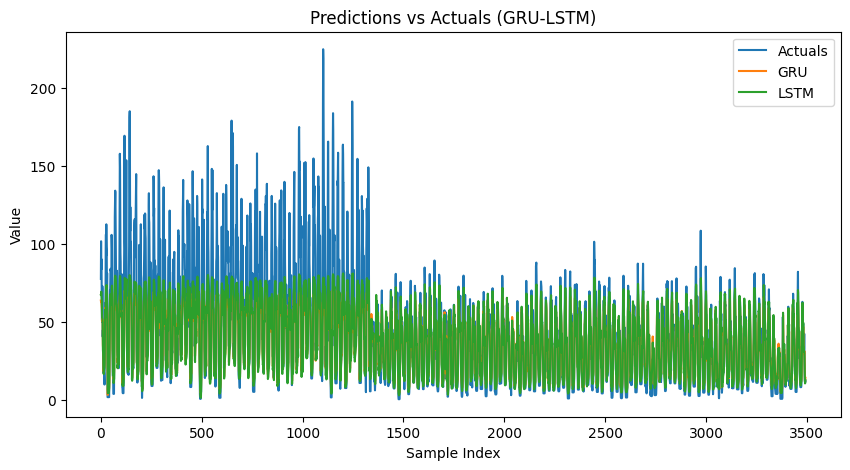

In [ ]:
actuals = []
for batch in colmod.predict_dataloader():
  x, y = batch
  actuals.extend(y.numpy())

actuals_flat = [item for sublist in actuals for item in sublist]

folder_path = f'Predictions/{combined_name}'
pt_files = [f for f in os.listdir(folder_path) if f.endswith('.pt')]

metrics = []
plt.figure(figsize=(10, 5))
plt.plot(actuals_flat, label='Actuals')

for i, pt_file in enumerate(pt_files):
  file_path = os.path.join(folder_path, pt_file)
  predictions = torch.load(file_path)
  model_name = pt_file.split('.')[0].split('_')[-1]

  if len(predictions) > len(actuals_flat):
    predictions = predictions[-len(actuals_flat):]
  if type(predictions[0]) == torch.Tensor: 
    predictions = [item.item() for sublist in predictions for item in sublist]
  elif type(predictions[0]) == np.float64:
    predictions = predictions.tolist()

  metrics.append({
    'model': model_name,
    'mse': mean_squared_error(predictions, actuals_flat),
    'mae': mean_absolute_error(predictions, actuals_flat),
    'mape': mean_absolute_percentage_error(predictions, actuals_flat)})
  plt.plot(predictions, label=model_name)

loss_func_df = pd.concat([pd.DataFrame([m]) for m in metrics])
loss_func_df.set_index('model', inplace=True)
print(loss_func_df)

plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title(f'Predictions vs Actuals ({combined_name})')
plt.legend()

plt.savefig(f'{folder_path}/predictions_vs_actuals_{combined_name}.png')
plt.show()

Model Name: GRU
Percentage of predictions below 95%: 25.40%
Percentage of predictions above 105%: 61.40%
Total percentage of predictions below actuals: 33.20%
Model Name: LSTM
Percentage of predictions below 95%: 25.60%
Percentage of predictions above 105%: 58.20%
Total percentage of predictions below actuals: 34.80%


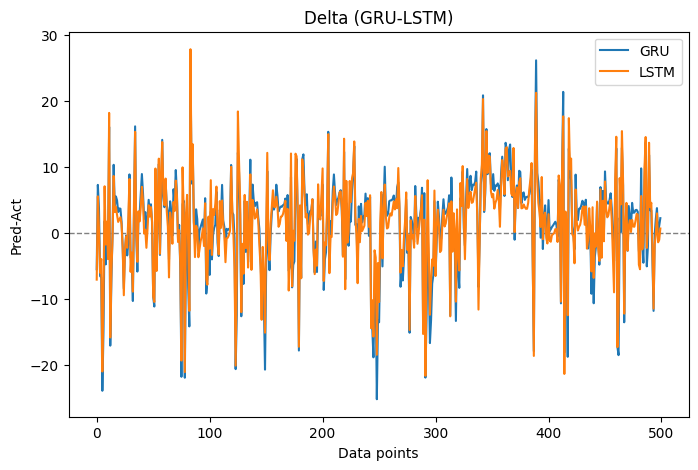

In [ ]:
actuals = []
for batch in colmod.predict_dataloader():
  x, y = batch
  actuals.extend(y.numpy())

actuals_flat = [item for sublist in actuals for item in sublist]

folder_path = f'Predictions/{combined_name}'
pt_files = [f for f in os.listdir(folder_path) if f.endswith('.pt')]

predictions = []
metrics = []

actuals_flat = actuals_flat[-500:]

plt.figure(figsize=(8, 5))
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title(f'Delta ({combined_name})')
plt.xlabel('Data points')
plt.ylabel('Pred-Act')
for i, pt_file in enumerate(pt_files):
    file_path = os.path.join(folder_path, pt_file)
    predictions = torch.load(file_path)
    model_name = pt_file.split('.')[0].split('_')[-1]

    if len(predictions) > len(actuals_flat):
        predictions = predictions[-len(actuals_flat):]
    if type(predictions[0]) == torch.Tensor: 
        predictions = [item.item() for sublist in predictions for item in sublist]
    elif type(predictions[0]) == np.float64:
        predictions = predictions.tolist()
    
    predictions = predictions[-500:]

    diff = np.array(predictions) - np.array(actuals_flat)
    plt.plot(diff, label=model_name)

    below_threshold = np.array(predictions) < (np.array(actuals_flat) * 0.95)
    above_threshold = np.array(predictions) > (np.array(actuals_flat) * 1.05)
    total_below_actuals = np.sum(np.array(predictions) < np.array(actuals_flat))
    percentage_below_threshold = np.sum(below_threshold) / len(predictions) * 100
    percentage_above_threshold = np.sum(above_threshold) / len(predictions) * 100
    percentage_total_below_actuals = total_below_actuals / len(predictions) * 100
    print(f"Model Name: {model_name}")
    print(f"Percentage of predictions below 95%: {percentage_below_threshold:.2f}%")
    print(f"Percentage of predictions above 105%: {percentage_above_threshold:.2f}%")
    print(f"Total percentage of predictions below actuals: {percentage_total_below_actuals:.2f}%")

plt.legend()
plt.show()


In [ ]:
%load_ext tensorboard
%tensorboard --logdir=lightning_logs

Launching TensorBoard...

In [ ]:
!tasklist | findstr tensorboard # find tensorboard pid
# !taskkill /PID 16220 /F # kill tensorboard with pid

FINDSTR: Cannot open #
FINDSTR: Cannot open find
FINDSTR: Cannot open tensorboard
FINDSTR: Cannot open pid
